In [1]:
import numpy as np
import time
import requests
import os
import pickle
from lxml import html
import numpy as np
import urllib.request
import face_recognition
import cv2
import matplotlib.pyplot as plt
import pytesseract
from googlesearch import search
from PIL import Image, ImageStat
import time
tt = time.time
st = tt()

In [10]:
# get prof name from thumbnail
def plot_image_list(img_list, figsize=(12, 12), subplot_n_cols=2):
    plt.figure(figsize=(12, 12))
    for i,img in enumerate(img_list):
        plt.subplot(int(len(img_list)/subplot_n_cols)+1, subplot_n_cols, i+1)
        try:
            plt.imshow(img)
        except:
            pass
        
def brightness(img):
    img = Image.fromarray(img)
    img = img.convert('L')
    stat = ImageStat.Stat(img)
    return stat.rms[0]

def is_valid_img(img, lthresh = 100, hthresh = 200):
    bright = brightness(img)
    print(bright)
    if bright<lthresh or bright>hthresh:
        return False
    else:
        return True
        
def get_extension_files(path_to_json, ext='.json'):
    json_files = [os.path.join(path_to_json, pos_json) for pos_json in os.listdir(path_to_json) if pos_json.endswith(ext)]
    return json_files

def flatten_list(l):
    return [item for sublist in l for item in sublist]

def post_processing(img):
    norm_img = np.zeros((img.shape[0], img.shape[1]))
    norm_img = cv2.normalize(img, norm_img, 0, 255,
                             cv2.NORM_MINMAX)
    return img

In [3]:
base_dir = 'C:\\Users\\YASH\\nptel_face_recognition'
known_faces_dir = os.path.join(base_dir, 'known_faces')
full_vedios_dir = os.path.join(base_dir, 'full_vedio')

known_images_path_list = get_extension_files(known_faces_dir, ext='.jpg') 
known_images_list = [w.split('\\')[-1] for w in known_images_path_list]
known_face_names = [w[:-4] for w in known_images_list]
known_face_image_list = [face_recognition.load_image_file(w) for w in known_images_path_list]
# known_face_encodings = [face_recognition.face_encodings(w)[0] for w in known_face_image_list]
filter_idx_list=[]
known_face_encodings=[]
for i,w in enumerate(known_face_image_list):
    enc = face_recognition.face_encodings(w)
    if enc!=[]:
        known_face_encodings.append(enc[0])
    else:
        filter_idx_list.append(i)
known_face_names = [known_face_names[i] for i in range(len(known_face_names)) if i not in filter_idx_list]

In [28]:
NUM_PLAYLISTS = 100
NUM_VEDIOS = 1
paylist_path_list = [x[0] for x in os.walk(full_vedios_dir)][1:]
paylist_path_list = paylist_path_list[:NUM_PLAYLISTS]
paylist_name_list = [x.split('\\')[-1] for x in paylist_path_list] 

print(f"number of paylist: {len(paylist_name_list)}\n")
for playlist, playlistn in zip(paylist_path_list, paylist_name_list):
    print(f"\npaylist: {playlistn}")
    vedio_path_list = get_extension_files(playlist, ext='.mp4')[:NUM_VEDIOS]
    vedio_name_list = [x.split('\\')[-1] for x in vedio_path_list] 
    print(f"number of vedios: {len(vedio_path_list)}")
    for vedio_path in vedio_path_list:
        vfname = vedio_path.split('\\')[-1]
        print(f"vedio: {vfname}")
        video_capture = cv2.VideoCapture(vedio_path)
                               
        # Initialize some variables
        face_locations = []
        face_encodings = []
        face_names = []
        process_this_frame = True
                               
        vst = 15
        vet = 25
        fps = int(video_capture.get(cv2.CAP_PROP_FPS))
        st = tt()
        i=-1
        while video_capture.isOpened():
            i+=1
            if int(i/fps) < vst:
                ret, frame = video_capture.read()
                continue

            if int(i/fps) > vet:
                break
            
             # Grab a single frame of video
            ret, frame = video_capture.read()

            # Resize frame of video to 1/4 size for faster face recognition processing
            small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)

            # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
            rgb_small_frame = small_frame[:, :, ::-1]

            # process
            NUM_FRAMES_PER_SEC = 1
            if i%int(fps/NUM_FRAMES_PER_SEC)==0:
                print(f"time: {int(i/fps)}")
                # Find all the faces and face encodings in the current frame of video
                face_locations = face_recognition.face_locations(rgb_small_frame)
                face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

                face_names = []
                for face_encoding in face_encodings:
                    # See if the face is a match for the known face(s)
                    matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
                    name = "Unknown"

                    # # If a match was found in known_face_encodings, just use the first one.
                    # if True in matches:
                    #     first_match_index = matches.index(True)
                    #     name = known_face_names[first_match_index]

                    # Or instead, use the known face with the smallest distance to the new face
                    face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
                    best_match_index = np.argmin(face_distances)
                    if matches[best_match_index]:
                        name = known_face_names[best_match_index]

                    face_names.append(name)

                # Display the results
                for (top, right, bottom, left), name in zip(face_locations, face_names):
                    # Scale back up face locations since the frame we detected in was scaled to 1/4 size
                    top *= 4
                    right *= 4
                    bottom *= 4
                    left *= 4

                    # Draw a box around the face
                    cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

                    # Draw a label with a name below the face
                    cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
                    font = cv2.FONT_HERSHEY_DUPLEX
                    cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

                # Display the resulting image
                cv2.imshow('Video', frame)

            # Hit 'q' on the keyboard to quit!
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

        # Release handle to the webcam
        video_capture.release()
        cv2.destroyAllWindows()


number of paylist: 10


paylist: Artificial Intelligence Search Methods for problem Solving
number of vedios: 1
vedio: AETGmGYy0UU.mp4
time: 15
time: 16
time: 17
time: 18
time: 19
time: 20
time: 21
time: 22
time: 23
time: 24
time: 25

paylist: Cloud Computing
number of vedios: 1
vedio: fZ3D6HQrWzs.mp4
time: 15
time: 16
time: 17
time: 18
time: 19
time: 20
time: 21
time: 22
time: 23
time: 24
time: 25

paylist: Compiler Design
number of vedios: 1
vedio: 7oB0urhzndk.mp4
time: 15
time: 16
time: 17
time: 18
time: 19
time: 20
time: 21
time: 22
time: 23
time: 24
time: 25

paylist: Computer Architecture Prof. Smruti Ranjan Sarangi
number of vedios: 1
vedio: 1rV15Z1mbwo.mp4
time: 15
time: 16
time: 17
time: 18
time: 19
time: 20
time: 21
time: 22
time: 23
time: 24
time: 25

paylist: Hardware Modeling using Verilog
number of vedios: 1
vedio: 6r4ja44Bq1k.mp4
time: 15
time: 16
time: 17
time: 18
time: 19
time: 20
time: 21
time: 22
time: 23
time: 24
time: 25

paylist: Introduction to Machine Learning
n

In [25]:
vedio_path = 'C:\\Users\\YASH\\nptel_face_recognition\\full_vedio\\Introduction to Machine Learning\\dYMCwxgl3vk.mp4'
vfname = vedio_path.split('\\')[-1]
print(f"vedio: {vfname}")
video_capture = cv2.VideoCapture(vedio_path)

# Initialize some variables
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True

vst = 20
vet = 25
fps = int(video_capture.get(cv2.CAP_PROP_FPS))
st = tt()
i=-1
img_list = []
while video_capture.isOpened():
    i+=1
    if int(i/fps) < vst:
        ret, frame = video_capture.read()
        continue

    if int(i/fps) > vet:
        break

     # Grab a single frame of video
    ret, frame = video_capture.read()

    # Resize frame of video to 1/4 size for faster face recognition processing
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)

    # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
    rgb_small_frame = small_frame[:, :, ::-1]

    # process
    NUM_FRAMES_PER_SEC = 1
    if i%int(fps/NUM_FRAMES_PER_SEC)==0:
        print(f"time: {int(i/fps)}")
        # Find all the faces and face encodings in the current frame of video
        rgb_small_frame = post_processing(rgb_small_frame)
        img_list.append(rgb_small_frame)
        face_locations = face_recognition.face_locations(rgb_small_frame)
        face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)
        print(f"number of faces found: {len(face_locations)}")

        face_names = []
        for face_encoding in face_encodings:
            # See if the face is a match for the known face(s)
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
            name = "Unknown"

            # # If a match was found in known_face_encodings, just use the first one.
            # if True in matches:
            #     first_match_index = matches.index(True)
            #     name = known_face_names[first_match_index]

            # Or instead, use the known face with the smallest distance to the new face
            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = known_face_names[best_match_index]

            face_names.append(name)

        # Display the results
        for (top, right, bottom, left), name in zip(face_locations, face_names):
            # Scale back up face locations since the frame we detected in was scaled to 1/4 size
            top *= 4
            right *= 4
            bottom *= 4
            left *= 4

            # Draw a box around the face
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

            # Draw a label with a name below the face
            cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

        # Display the resulting image
        cv2.imshow('Video', frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Release handle to the webcam
video_capture.release()
cv2.destroyAllWindows()

vedio: dYMCwxgl3vk.mp4
time: 20
number of faces found: 0
time: 21
number of faces found: 0
time: 22
number of faces found: 0
time: 23
number of faces found: 0
time: 24
number of faces found: 0
time: 25
number of faces found: 0


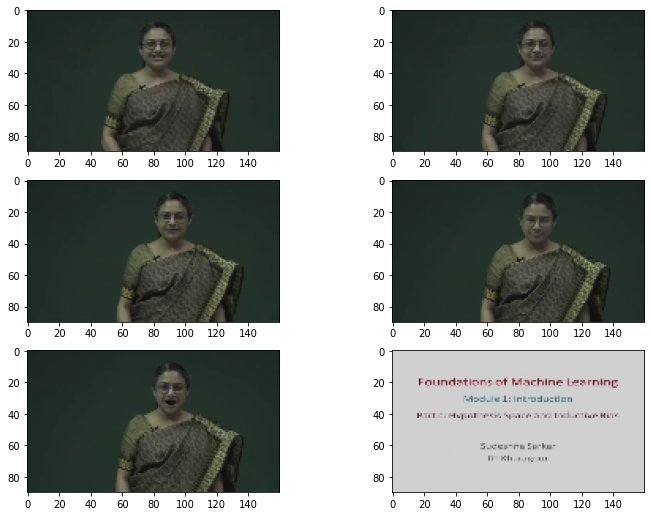

In [26]:
plot_image_list(img_list)